<a href="https://colab.research.google.com/github/sunfflur/frequency-learning/blob/master/ODR/Exp_ODR2_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MobileNetV2

#### Libraries Import

In [ ]:
s = 23
import os
os.environ['PYTHONHASHSEED']=str(s)
import random
random.seed(s)
from numpy.random import seed
seed(s)
from tensorflow.random import set_seed
set_seed(s)

import PIL
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Conv1D, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
#from sklearn.metrics import confusion_matrix
import seaborn as sn

#!pip install tensorflow-addons 
#!pip install tensorflow-recommenders

#import tensorflow_addons as tfa
#import tensorflow_recommenders as tfrs

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun May 14 17:49:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


#### Drive mount

In [ ]:
### TESSSSSST ###

!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&

In [ ]:
!sudo apt-get install -qq w3m # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package w3m.
(Reading database ... 122524 files and directories currently installed.)
Preparing to unpack .../w3m_0.5.3-37ubuntu0.1_amd64.deb ...
Unpacking w3m (0.5.3-37ubuntu0.1) ...
Setting up w3m (0.5.3-37ubuntu0.1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for mime-support (3.64ubuntu1) ...
/content
/content/drive
/content
/
Access token retrieved correctly.


#### Data Load

In [ ]:
### data loading ### 
path_train = '/content/drive/MyDrive/Mestrado/Experimentos/exp-retina/exp-retina-data/square-grouping/3_levels/x_train_odir2.npy'
path_ytrain = '/content/drive/MyDrive/Mestrado/Experimentos/exp-retina/exp-retina-data/square-grouping/3_levels/y_train_odir2.npy'

path_valid = '/content/drive/MyDrive/Mestrado/Experimentos/exp-retina/exp-retina-data/square-grouping/3_levels/x_valid_odir2.npy'
path_yvalid = '/content/drive/MyDrive/Mestrado/Experimentos/exp-retina/exp-retina-data/square-grouping/3_levels/y_valid_odir2.npy'

path_test = '/content/drive/MyDrive/Mestrado/Experimentos/exp-retina/exp-retina-data/square-grouping/3_levels/x_test_odir2.npy'
path_ytest = '/content/drive/MyDrive/Mestrado/Experimentos/exp-retina/exp-retina-data/square-grouping/3_levels/y_test_odir2.npy'

x_train, x_valid, x_test = np.load(path_train), np.load(path_valid), np.load(path_test)
y_train, y_valid, y_test = np.load(path_ytrain), np.load(path_yvalid), np.load(path_ytest)
#x_train, x_test = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1), x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

# adjust dimension and change from array to tensor + convert to 3 channel images
new_shape = (224,224)
x_train, x_valid, x_test = tf.image.resize(x_train, new_shape), tf.image.resize(x_valid, new_shape), tf.image.resize(x_test, new_shape)

#### Pre-trained Model

In [ ]:
# prepare the image for the MobileNet model
x_train1 = preprocess_input(x_train)
x_valid1 = preprocess_input(x_valid)
x_test1 = preprocess_input(x_test)

In [ ]:
def pre_trained_model(input_shape, n_classes, optimizer, fine_tune=0):
    """
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training.
    fine_tune: int - The number of pre-trained layers to unfreeze. 
               0 = all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    mobilenet_model = MobileNetV2(include_top=True,
                                  alpha=1.0,
                                  weights='imagenet',
                                  input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    
    if fine_tune > 0:
        for layer in mobilenet_model.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in mobilenet_model.layers:
            layer.trainable = False
    
    '''
    # Turn all the layers trainable.
    for layer in mobilenet_model.layers:
      layer.trainable = True
    '''
    
    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = mobilenet_model.layers[-2].output
    output_layer = Dense(n_classes, activation='softmax', name='my_predictions')(top_model)
    
    # Group the convolutional base and new output into a Model object.
    model = Model(inputs=mobilenet_model.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
tf.random.set_seed(s) #s

opt = Adam(learning_rate=0.0001)
MobileNetV2_model = pre_trained_model(input_shape=(224,224,3), n_classes=2, optimizer=opt)

14536120/14536120 [==============================] - 0s 0us/step


In [ ]:
print(MobileNetV2_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
# ModelCheckpoint callback - save best weights tempo:4min12s
estopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Mestrado/Experimentos/exp-retina/exp-retina-pynb/model_odr2_mobilenetv2.weights.best.hdf5', save_best_only=True, verbose=0)
history = MobileNetV2_model.fit(x_train1, y_train, validation_data=(x_valid1, y_valid), epochs=100, batch_size=16, verbose=1, shuffle=True, callbacks=[checkpoint, estopping]) #validation_split=0.1,

Epoch 1/100
45/45 [==============================] - 18s 140ms/step - loss: 1.0329 - accuracy: 0.4965 - val_loss: 0.7983 - val_accuracy: 0.4274
Epoch 2/100
45/45 [==============================] - 3s 70ms/step - loss: 0.6033 - accuracy: 0.6582 - val_loss: 0.4807 - val_accuracy: 0.8205
Epoch 3/100
45/45 [==============================] - 3s 71ms/step - loss: 0.4219 - accuracy: 0.8298 - val_loss: 0.3497 - val_accuracy: 0.8718
Epoch 4/100
45/45 [==============================] - 3s 75ms/step - loss: 0.3396 - accuracy: 0.8823 - val_loss: 0.2942 - val_accuracy: 0.9060
Epoch 5/100
45/45 [==============================] - 3s 66ms/step - loss: 0.2978 - accuracy: 0.8922 - val_loss: 0.2656 - val_accuracy: 0.9145
Epoch 6/100
45/45 [==============================] - 3s 68ms/step - loss: 0.2760 - accuracy: 0.8865 - val_loss: 0.2511 - val_accuracy: 0.9145
Epoch 7/100
45/45 [==============================] - 3s 68ms/step - loss: 0.2605 - accuracy: 0.8894 - val_loss: 0.2383 - val_accuracy: 0.9231
Epoc

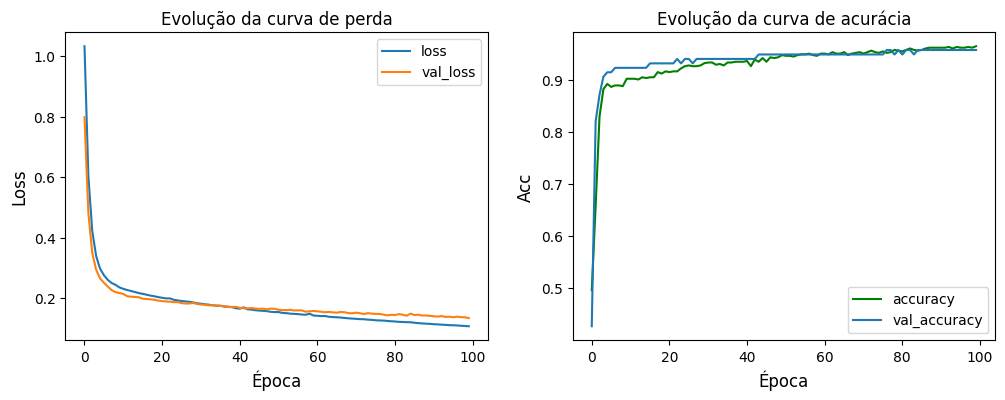

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121), plt.plot(history.history['loss'], label='loss')
plt.subplot(121), plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Época', fontsize=12), plt.ylabel('Loss', fontsize=12)
plt.title('Evolução da curva de perda')
plt.legend()
plt.subplot(122), plt.plot(history.history['accuracy'], label = 'accuracy', color='green')
plt.subplot(122), plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Época', fontsize=12), plt.ylabel('Acc', fontsize=12)
plt.title('Evolução da curva de acurácia')
plt.legend()
plt.show()

In [ ]:
MobileNetV2_model.load_weights('/content/drive/MyDrive/Mestrado/Experimentos/exp8 - ALOT/exp8-pynb/model_mobilenetv2.weights.best.hdf5')

In [ ]:
### TEST ACC ###
with tf.device('CPU:0'):
  scores = MobileNetV2_model.evaluate(x_test1, y_test)
  print('\n%s : %.2f%%' % (MobileNetV2_model.metrics_names[1], scores[1] * 100))

11/11 [==============================] - 7s 602ms/step - loss: 0.1907 - accuracy: 0.8997

accuracy : 89.97%


#### Random initialization

In [ ]:
# prepare the image for the MobileNet model
x_train1 = preprocess_input(x_train)
x_valid1 = preprocess_input(x_valid)
x_test1 = preprocess_input(x_test)

In [ ]:
def non_pre_trained_model(input_shape, n_classes, optimizer, fine_tune=0):
    """
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training.
    fine_tune: int - The number of pre-trained layers to unfreeze. 
               0 = all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    mobilenet_model = MobileNetV2(include_top=True,
                                  alpha=1.0,
                                  weights=None,
                                  input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    '''
    if fine_tune > 0:
        for layer in mobilenet_model.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in mobilenet_model.layers:
            layer.trainable = False
    '''
    
    # Turn all the layers trainable.
    for layer in mobilenet_model.layers:
      layer.trainable = True
    
    
    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = mobilenet_model.layers[-2].output
    output_layer = Dense(n_classes, activation='softmax', name='my_predictions')(top_model)
    
    # Group the convolutional base and new output into a Model object.
    model = Model(inputs=mobilenet_model.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
tf.random.set_seed(s) #s

opt = Adam(learning_rate=0.0001)
MobileNetV2_model = non_pre_trained_model(input_shape=(224,224,3), n_classes=2, optimizer=opt)

In [ ]:
print(MobileNetV2_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
# ModelCheckpoint callback - save best weights tempo:3min14s
estopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Mestrado/Experimentos/exp-retina/exp-retina-pynb/model_odr2_mobilenetv2_rdn.weights.best.hdf5', save_best_only=True, verbose=0)
history = MobileNetV2_model.fit(x_train1, y_train, validation_data=(x_valid1, y_valid), epochs=100, batch_size=16, verbose=1, shuffle=True, callbacks=[checkpoint, estopping]) #, estoppingvalidation_split=0.1

Epoch 1/100
45/45 [==============================] - 40s 201ms/step - loss: 0.5621 - accuracy: 0.7078 - val_loss: 0.6926 - val_accuracy: 0.6325
Epoch 2/100
45/45 [==============================] - 6s 132ms/step - loss: 0.4560 - accuracy: 0.7858 - val_loss: 0.6903 - val_accuracy: 0.6325
Epoch 3/100
45/45 [==============================] - 6s 132ms/step - loss: 0.3964 - accuracy: 0.8227 - val_loss: 0.6871 - val_accuracy: 0.6325
Epoch 4/100
45/45 [==============================] - 3s 71ms/step - loss: 0.3509 - accuracy: 0.8525 - val_loss: 0.6883 - val_accuracy: 0.6325
Epoch 5/100
45/45 [==============================] - 6s 126ms/step - loss: 0.3168 - accuracy: 0.8681 - val_loss: 0.6843 - val_accuracy: 0.6325
Epoch 6/100
45/45 [==============================] - 3s 74ms/step - loss: 0.2645 - accuracy: 0.8908 - val_loss: 0.6871 - val_accuracy: 0.6325
Epoch 7/100
45/45 [==============================] - 3s 74ms/step - loss: 0.2491 - accuracy: 0.9035 - val_loss: 0.6851 - val_accuracy: 0.6325
E

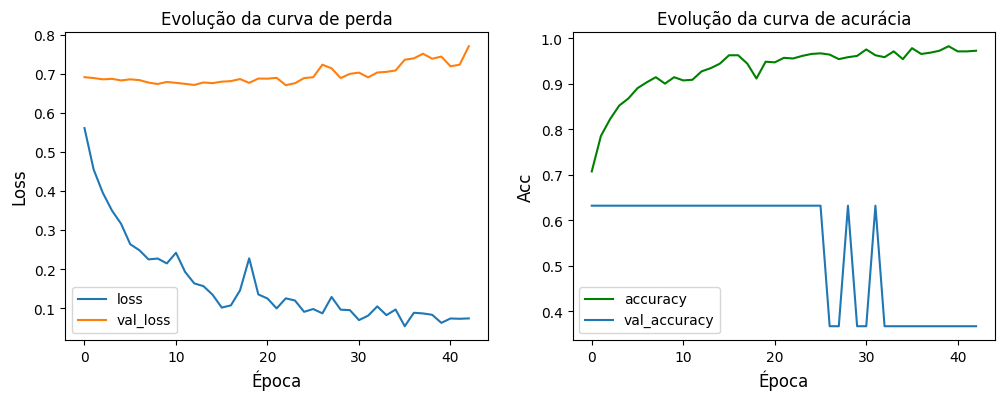

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121), plt.plot(history.history['loss'], label='loss')
plt.subplot(121), plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Época', fontsize=12), plt.ylabel('Loss', fontsize=12)
plt.title('Evolução da curva de perda')
plt.legend()
plt.subplot(122), plt.plot(history.history['accuracy'], label = 'accuracy', color='green')
plt.subplot(122), plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Época', fontsize=12), plt.ylabel('Acc', fontsize=12)
plt.title('Evolução da curva de acurácia')
plt.legend()
plt.show()

In [ ]:
### TEST ACC ###
with tf.device('CPU:0'):
  scores = MobileNetV2_model.evaluate(x_test1, y_test)
  print('\n%s : %.2f%%' % (MobileNetV2_model.metrics_names[1], scores[1] * 100))

11/11 [==============================] - 7s 659ms/step - loss: 0.7186 - accuracy: 0.4928

accuracy : 49.28%
